In [198]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [199]:
start = time.time()
df = pd.read_csv('co2_data.csv')
end = time.time()
print("Loading took " + str(round(end - start, 2)) + " seconds")

Loading took 0.0 seconds


In [200]:
df.head(5)

,CO2,Year&Month,Year
0,333.13,1974.38,1974
1,332.09,1974.46,1974
2,331.10,1974.54,1974
3,329.14,1974.63,1974
4,327.36,1974.71,1974


In [201]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import random

def plot_seasonal_decompose(df, column_name, model='additive', period=None):
    """
    Perform seasonal decomposition on a time series and plot the results.
    Parameters:
    df (DataFrame): The input DataFrame containing the time series data.
    column_name (str): The name of the column in the DataFrame to decompose.
    model (str): The type of decomposition ('additive' or 'multiplicative'). Default is 'additive'.
    period (int): The number of observations per cycle. If None, it will be inferred.
    Returns:
    None
    """
    # Perform seasonal decomposition
    result = seasonal_decompose(df[column_name], model=model, period=period)
    trend = result.trend.dropna()
    seasonal = result.seasonal.dropna()
    residual = result.resid.dropna()

    # Generate random colors for each plot
    base_color = [random.random() for _ in range(3)]  # Generate a random RGB color

    # Plotting the decomposition with random colors
    plt.figure(figsize=(10, 10))
    plt.suptitle('Seasonal Decomposition of ' + column_name, fontsize=16)
    plt.subplot(4, 1, 1)
    plt.plot(df[column_name], color=base_color, label='Original Series')
    plt.legend(loc='upper left')
    
    plt.subplot(4, 1, 2)
    plt.plot(trend, color=base_color, label='Trend')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal, color=base_color, label='Seasonal')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(residual, color=base_color, label='Residuals')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


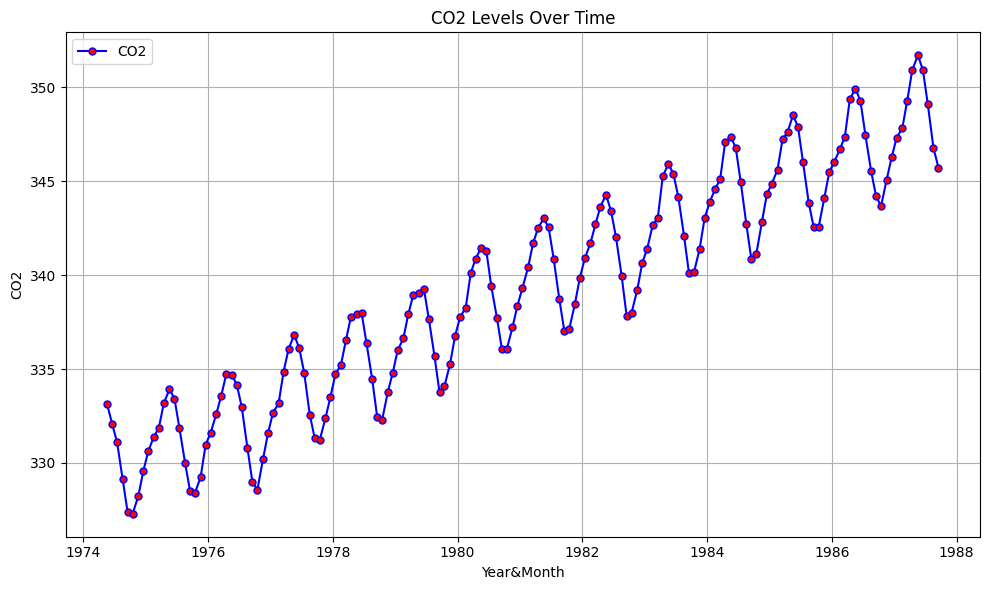

In [202]:
def plot_levels_overtime(df, x_column="Year&Month", y_column="CO2"):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_column], df[y_column], marker='o', markersize=5, markerfacecolor='red', color='blue', label=y_column)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f"{y_column} Levels Over Time")
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


plot_levels_overtime(df, 'Year&Month', 'CO2')

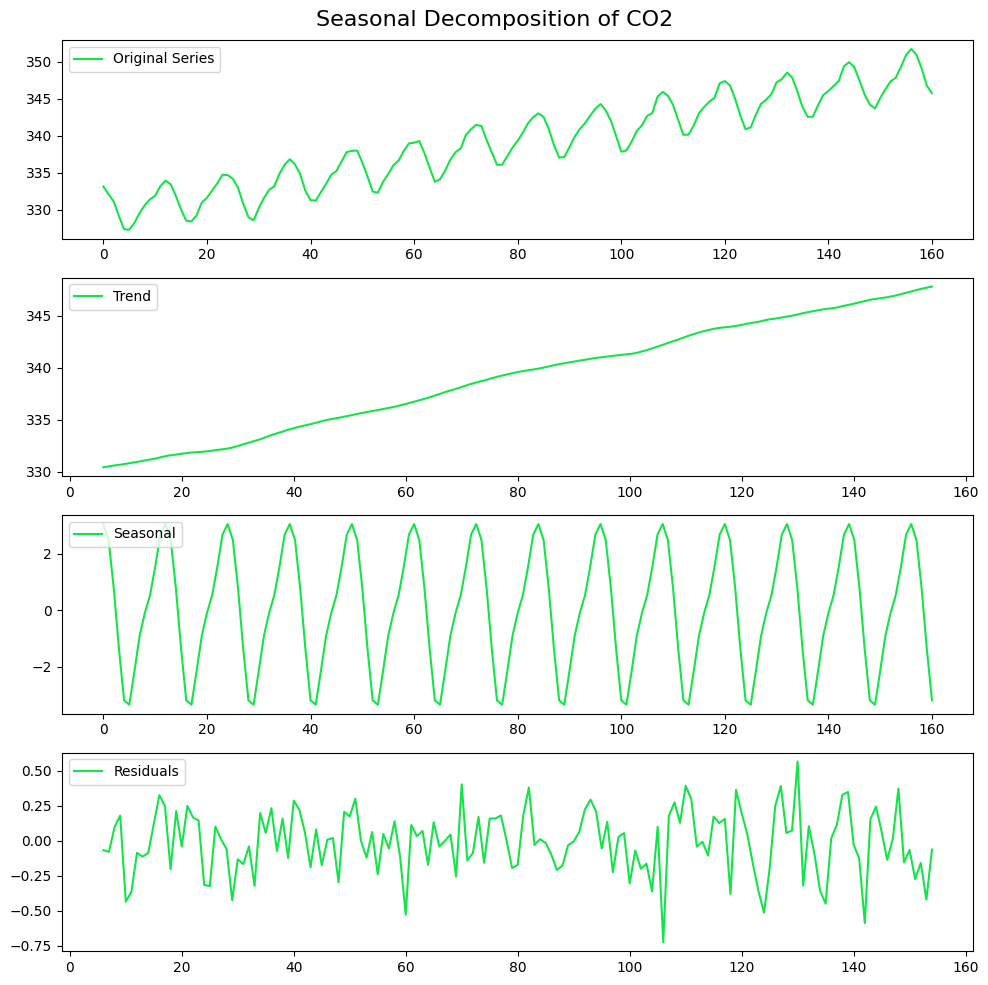

In [203]:
plot_seasonal_decompose(df, column_name='CO2', model='additive', period=12)

In [204]:
import pandas as pd

def create_lag_features(df, lags, stats, columns_to_lag):
    new_dfs = []
    new_columns = {}
    for lag in lags:
        for stat in stats:
            for col in columns_to_lag:
                if col not in df.columns:
                    print(f"⚠️ Warning: Column '{col}' not found in DataFrame!")
                    continue
                if lag == 1:
                    new_column_name = f"{col}_lag{lag}"
                    new_columns[new_column_name] = df[col].shift(lag)

                elif col == "Wind" or col == "Condition":
                    if stat == "":
                        new_column_name = f"{col}_lag{lag}"
                        new_columns[new_column_name] = df[col].shift(lag)

                else:
                    if stat == "":
                        new_column_name = f"{col}_lag{lag}"
                        new_columns[new_column_name] = df[col].shift(lag)

                    elif stat == "mean":
                        new_column_name = f"{col}_lag{lag}_mean"
                        new_columns[new_column_name] = df[col].shift(lag//2).rolling(window=lag, center=True).mean()

                    elif stat == "std":
                        new_column_name = f"{col}_lag{lag}_std"
                        new_columns[new_column_name] = df[col].shift(lag//2).rolling(window=lag, center=True).std()

                    elif stat == "max":
                        new_column_name = f"{col}_lag{lag}_max"
                        new_columns[new_column_name] = df[col].shift(lag//2).rolling(window=lag, center=True).max()

                    elif stat == "min":
                        new_column_name = f"{col}_lag{lag}_min"
                        new_columns[new_column_name] = df[col].shift(lag//2).rolling(window=lag, center=True).min()

                    elif stat == "sum":
                        new_column_name = f"{col}_lag{lag}_sum"
                        new_columns[new_column_name] = df[col].shift(lag//2).rolling(window=lag, center=True).sum()

        result_df = pd.concat([df, pd.DataFrame(new_columns, index=df.index)], axis=1)
        
        # result_df = result_df.bfill()
        
        result_df = result_df.dropna().reset_index(drop=True)

        new_dfs.append(result_df)

    return new_dfs , result_df


In [205]:
lags = [1,2,4,8,16]
stats = ["","mean","max","min"]
columns_to_lag =["CO2"]

In [206]:
lag_df , result_df_new= create_lag_features(df, lags, stats, columns_to_lag)

In [207]:
# กำหนดลำดับที่ต้องการ
desired_order = [
    "CO2",
    "CO2_lag1",
    "CO2_lag2",
    "CO2_lag4",
    "CO2_lag8",
    "CO2_lag16"
]

# จัดกลุ่ม min, max, mean
stat_order = ["min", "max", "mean"]

# ดึงคอลัมน์ min, max, mean ที่เกี่ยวข้อง
stat_columns = [col for col in result_df_new.columns if any(stat in col for stat in stat_order)]

# รวมลำดับคอลัมน์ใหม่
new_order = ["Year&Month"] + desired_order + stat_columns

# เรียง DataFrame ตามลำดับใหม่
result_df_new = result_df_new[new_order]


In [208]:
result_df_new.head()

,Year&Month,CO2,CO2_lag1,CO2_lag2,CO2_lag4,CO2_lag8,CO2_lag16,CO2_lag2_mean,CO2_lag2_max,CO2_lag2_min,CO2_lag4_mean,CO2_lag4_max,CO2_lag4_min,CO2_lag8_mean,CO2_lag8_max,CO2_lag8_min,CO2_lag16_mean,CO2_lag16_max,CO2_lag16_min
0,1975.71,328.51,330.01,331.85,333.92,330.62,333.13,330.93,331.85,330.01,332.3025,333.92,330.01,332.03500,333.92,330.01,330.885625,333.92,327.29
1,1975.79,328.41,328.51,330.01,333.43,331.40,332.09,329.26,330.01,328.51,330.9500,333.43,328.51,331.77125,333.92,328.51,330.596875,333.92,327.29
2,1975.88,329.25,328.41,328.51,331.85,331.87,331.10,328.46,328.51,328.41,329.6950,331.85,328.41,331.39750,333.92,328.41,330.366875,333.92,327.29
3,1975.96,330.97,329.25,328.41,330.01,333.18,329.14,328.83,329.25,328.41,329.0450,330.01,328.41,331.07000,333.92,328.41,330.251250,333.92,327.29
4,1976.04,331.60,330.97,329.25,328.51,333.92,327.36,330.11,330.97,329.25,329.2850,330.97,328.41,330.79375,333.92,328.41,330.365625,333.92,327.29


In [209]:
import matplotlib.pyplot as plt

def plot_train_test_split(df, index_column, target_column, exog_columns=None, train_size=0.75, figsize=(15, 8)):
    """
    Parameters:
    - df: DataFrame ที่มีข้อมูล
    - index_column: ชื่อคอลัมน์ที่จะตั้งเป็น index
    - target_column: ชื่อคอลัมน์เป้าหมาย (target) ที่ต้องการวิเคราะห์
    - exog_columns: รายชื่อคอลัมน์ของตัวแปรเสริม (exogenous variables), ถ้าไม่มีให้เป็น None
    - train_size: สัดส่วนของข้อมูลที่ใช้สำหรับการฝึก (ค่าเริ่มต้น: 0.8 หรือ 80% ของข้อมูล)
    - figsize: ขนาดของกราฟ (ค่าเริ่มต้น: (15, 8))
    """
    # ตรวจสอบคอลัมน์
    if index_column not in df.columns:
        raise ValueError(f"'{index_column}' not found in the DataFrame columns.")
    if target_column not in df.columns:
        raise ValueError(f"'{target_column}' not found in the DataFrame columns.")
    if df[index_column].duplicated().any():
        raise ValueError(f"'{index_column}' contains duplicate values. Please ensure it is unique.")
    
    # ตั้งค่าคอลัมน์ที่ใช้เป็น index
    df = df.set_index(index_column, drop=False)
    
    # คำนวณจุดแบ่งข้อมูล
    split_point = int(len(df) * train_size)
    
    # แยกข้อมูลการฝึก (train) และการทดสอบ (test) สำหรับ target
    train_data = df.iloc[:split_point][[target_column]].rename(columns={target_column: 'train'})
    test_data = df.iloc[split_point:][[target_column]].rename(columns={target_column: 'test'})

    # ถ้ามี exogenous variables (ตัวแปรเสริม) ก็ให้แยกออกมาด้วย
    if exog_columns:
        exog_train = df.iloc[:split_point][exog_columns]
        exog_test = df.iloc[split_point:][exog_columns]
    else:
        exog_train = exog_test = None
    
    # รวมข้อมูล train และ test สำหรับ target
    combined_target = train_data.join(test_data, how='outer')

    # วาดกราฟของ target (ตัวแปรเป้าหมาย)
    combined_target.plot(y=['train', 'test'], figsize=figsize, fontsize=12)
    plt.xlabel(index_column, fontsize=12)
    plt.ylabel(target_column, fontsize=12)
    plt.title(f"Train-Test Split of {target_column} by {index_column}", fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # คืนค่าข้อมูลในรูปแบบ DataFrame
    # train_data = train_data.reset_index(drop=True)
    # test_data = test_data.reset_index(drop=True)
    # if exog_columns:
    #     exog_train = exog_train.reset_index(drop=True)
    #     exog_test = exog_test.reset_index(drop=True)
    
    print('Training data shape (target): ', train_data.shape)
    print('Test data shape (target): ', test_data.shape)

    if exog_columns:
        print('Training data shape (exog): ', exog_train.shape)
        print('Test data shape (exog): ', exog_test.shape)
    
    # train_index = np.arange(0, len(train_data))
    # test_index = np.arange(len(train_data), len(train_data) + len(test_data))
    # train_data = pd.Series(train_data.values.flatten(), index=train_index)
    # test_data = pd.Series(test_data.values.flatten(), index=test_index)

    return train_data, test_data, exog_train, exog_test


In [210]:
result_df_new.keys()

Index(['Year&Month', 'CO2', 'CO2_lag1', 'CO2_lag2', 'CO2_lag4', 'CO2_lag8',
       'CO2_lag16', 'CO2_lag2_mean', 'CO2_lag2_max', 'CO2_lag2_min',
       'CO2_lag4_mean', 'CO2_lag4_max', 'CO2_lag4_min', 'CO2_lag8_mean',
       'CO2_lag8_max', 'CO2_lag8_min', 'CO2_lag16_mean', 'CO2_lag16_max',
       'CO2_lag16_min'],
      dtype='object')

In [211]:
exog_columns =['CO2_lag1', 'CO2_lag2', 'CO2_lag4', 'CO2_lag8',
       'CO2_lag16', 'CO2_lag2_mean', 'CO2_lag2_max', 'CO2_lag2_min',
       'CO2_lag4_mean', 'CO2_lag4_max', 'CO2_lag4_min', 'CO2_lag8_mean',
       'CO2_lag8_max', 'CO2_lag8_min', 'CO2_lag16_mean', 'CO2_lag16_max',
       'CO2_lag16_min']

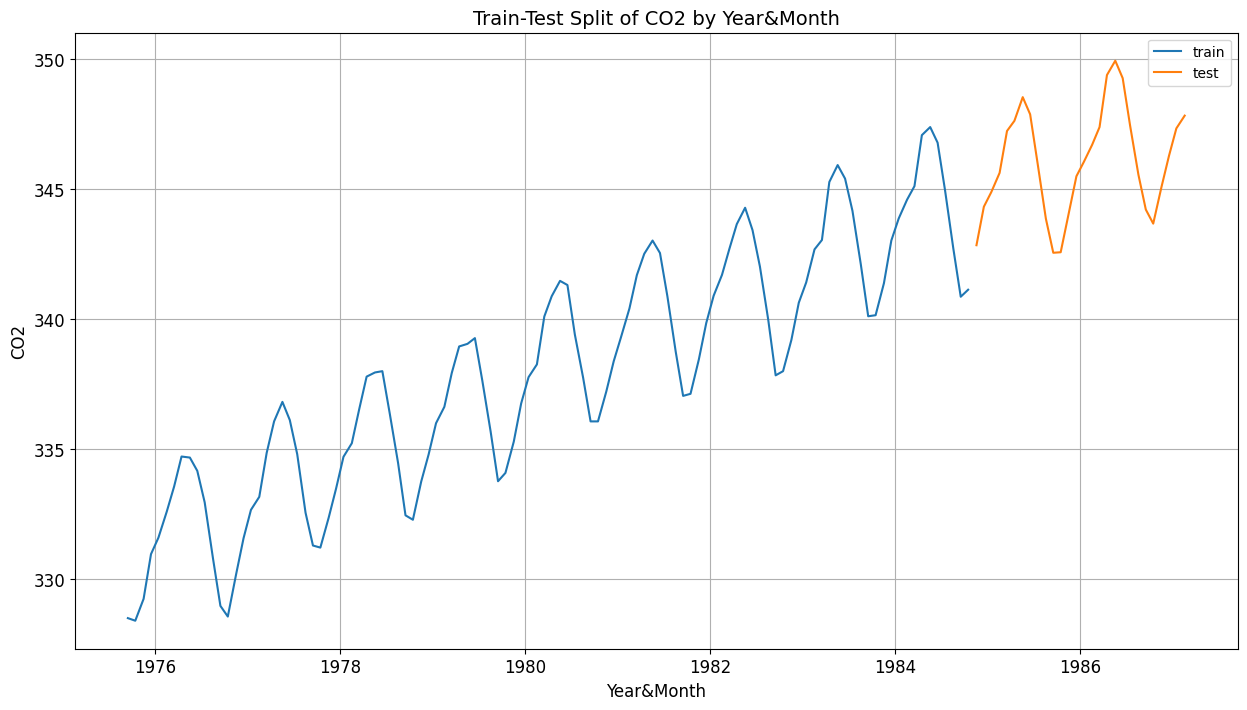

Training data shape (target):  (110, 1)
Test data shape (target):  (28, 1)
Training data shape (exog):  (110, 17)
Test data shape (exog):  (28, 17)


In [212]:
train_data, test_data, exog_train, exog_test = plot_train_test_split(result_df_new, index_column='Year&Month',target_column='CO2',
                                    exog_columns=exog_columns,train_size=0.8)

In [213]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm  
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [214]:
SARIMAX_model = pm.auto_arima(train_data,
                           exogenous=exog_train,
                           start_p=0, 
                           start_q=0,
                           test='adf',  # ใช้ ADF test เพื่อหา d
                           max_p=3, # ปรับเปลี่ยนตามความซับซ้อนของข้อมูล
                           max_q=3, # คล้ายกับ max_p ปรับเปลี่ยนให้เข้ากับข้อมูลเพื่อเพิ่มความสามารถของโมเดลในการคำนวณความผิดพลาด
                           m=52, # m คือ seasonality (12 สำหรับข้อมูลรายเดือน)
# ข้อมูลรายเดือน: m=12
# ข้อมูลรายไตรมาส: m=4
# ข้อมูลรายสัปดาห์: m=52
# ข้อมูลรายวัน:  m=7
                           start_P=0, # เริ่มต้นที่ 0 แต่สามารถเปลี่ยนได้ถ้าคุณเชื่อว่ามีอิทธิพลจากฤดูกาลในช่วงก่อนหน้า
                           seasonal=True,
                           d=None, # None
                           D=1,  # ให้ auto_arima ค้นหา d ที่เหมาะสม
                           trace=True, # ติดตามความก้าวหน้าในการสร้างโมเดล
                           error_action='ignore', # แสดงเตือนเมื่อเกิดข้อผิดพลาด 
                           suppress_warnings=True, # แสดงข้อความเตือนในระหว่างการทำงาน
                           stepwise=True) # True

# ดูค่าที่ auto_arima คำนวณได้
SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=324.235, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=254.706, Time=2.58 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=264.736, Time=2.44 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=403.349, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=252.857, Time=0.19 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=254.705, Time=1.80 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=9.80 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=166.980, Time=0.42 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=5.73 sec
 ARIMA(2,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=7.18 sec
 ARIMA(2,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=6.31 sec
 ARIMA(3,0,0)(0,1,0)[52] intercept   : AIC=168.955, Time=0.60 sec
 ARIMA(2,0,1)(0,1,0)[52] intercept   : AIC=168.954, Time=0.51 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=215.561, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  110
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 52)   Log Likelihood                 -79.490
Date:                           อา., 16 ก.พ. 2025   AIC                            166.980
Time:                                    17:43:37   BIC                            175.222
Sample:                                         0   HQIC                           170.190
                                            - 110                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9868      0.390      5.089      0.000       1.222       2.752
ar.L1          1.5985      0.085     18.770      0.000       1.432       1.765
ar.L2         -0.8942      0.090     -9.986      0.000      -1.070      -0.719
sigma2         0.8405      0.139      6.035      0.000       0.568       1.113
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.93
Prob(Q):                              0.92   Prob(JB):                         0.14
Heteroskedasticity (H):               1.68   Skew:                             0.47
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [230]:
n_periods = len(test_data)
fc, confint = SARIMAX_model.predict(n_periods=n_periods, exogenous=exog_test, return_conf_int=True)

d:\Anaconda\envs\Times\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


d:\Anaconda\envs\Times\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


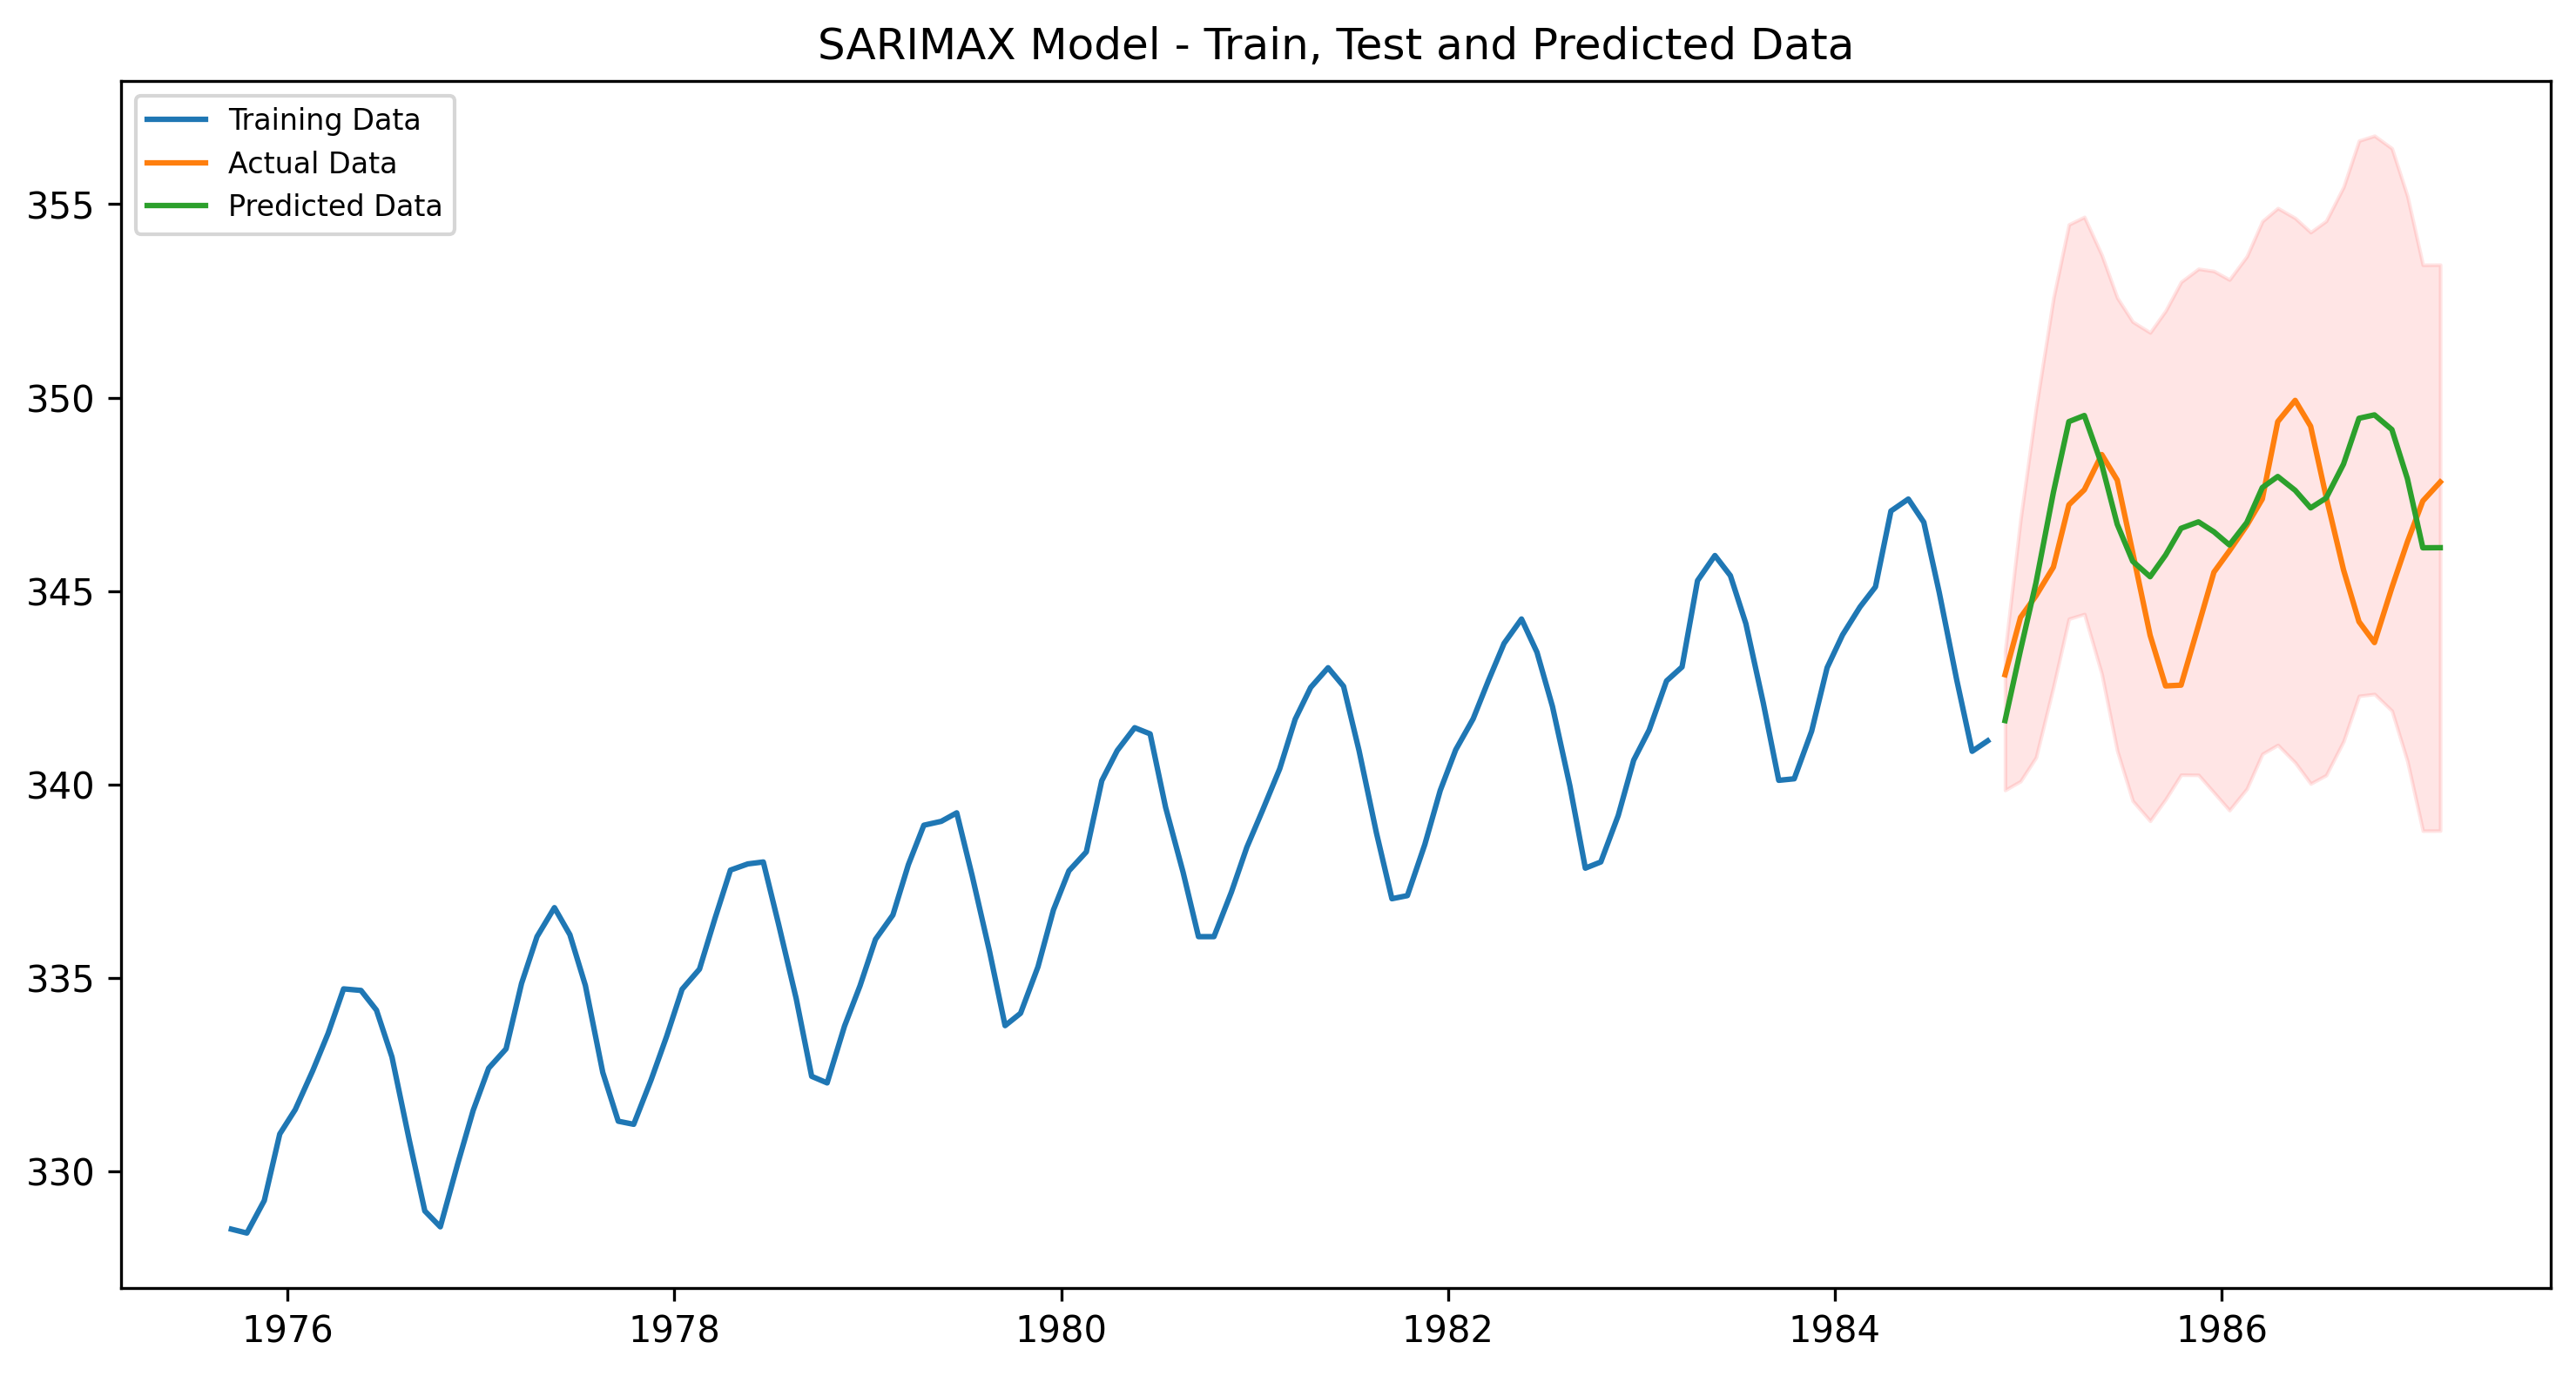

In [ ]:
# Predict the data
n_periods = len(test_data)
fc, confint = SARIMAX_model.predict(n_periods=n_periods, exogenous=exog_test, return_conf_int=True)
index_of_fc = test_data.index

df_fc = pd.DataFrame(list(fc.items()), columns=['Index', 'Value'])
df_fc.drop('Index', axis=1, inplace=True)
df_fc["index"] = test_data.index
df_fc = df_fc.set_index("index", drop=False)
df_fc.drop('index', axis=1, inplace=True)

# fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot the data
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Data')
plt.plot(df_fc, label='Predicted Data')
plt.fill_between(lower_series.index, lower_series, upper_series, color='r', alpha=0.1)
plt.title('SARIMAX Model - Train, Test and Predicted Data')
plt.legend(loc='upper left', fontsize=8)
plt.show()